In [50]:
from statistics import mean
import seaborn as sns
import networkx as nx
import pandas as pd
import time
import datetime
import freeman as fm
import operator
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy

Carregamento das bases de dados

In [2]:
data = pd.read_csv('bill/hotStuff.csv')

In [3]:
data2 = pd.read_excel('bill/hot100.xlsx')

In [4]:
def filtro(musica):
    new = musica.replace("#","")
    new = new.replace('"',"")
    new = new.replace("'","")
    new=new.replace("(","")
    new=new.replace(")","")
    new=new.replace("[","")
    new=new.replace("]","")
    new=new.replace("ç","c")
    new=new.replace("é","e")
    new=new.replace("ñ","n")
    new=new.replace("ò","o")
    new=new.replace("¿","?")
    new=new.replace("ó","o")
    new=new.replace("á","a")
    new=new.replace("ö","o")
    new=new.replace("Ó","O")
    new=new.replace("à","a")
    new=new.replace("�","?")
    
    
    return new

In [5]:
def sum100(number):
    return 100-number

In [6]:
def inv(number):
    return 1/number

In [7]:
def log(number):
    return np.log(number)

In [8]:
def loginv(number):
    return (1/(np.log(number)+1))

In [9]:
dic_func={sum100:"sum100",
          inv:"inv",
          log:"log",
          loginv:"loginv"}

In [10]:
l_drop=['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness']

In [11]:
def variaveis(dataf, year):
    dataframe=dataf[year].copy()
    
    def go_to_apply (dici,row):
        return dici[row['SongID']]

    for i in dic_func:
        name=dic_func[i]
        func=i
        dic={}
        for i in dataframe.index:
            if (dataframe["SongID"][i]) in dic:
                
                dic[dataframe["SongID"][i]] += func(dataframe["Week Position"][i])
            else:
                dic[dataframe["SongID"][i]] = func(dataframe["Week Position"][i])
        
        dataframe[name] = dataframe.apply (lambda row: go_to_apply(dic, row), axis=1)
        
    dataframe.drop_duplicates(subset="SongID", keep="last", inplace=True)
    
    dataframe=dataframe.reset_index(drop=True)
    return dataframe

In [12]:
def diats(row):
    return pd.Timestamp(row["WeekID"])

In [13]:
data['timestamp']=data.apply (lambda row: diats(row), axis=1)

In [14]:
def musica_filtrada (row):
   return filtro(row['SongID'])

In [15]:
data2['SongFiltred']=data2.apply (lambda row: musica_filtrada(row), axis=1)

In [16]:
dic_anos={}
for ano in range(2000,2020):
    v1="1/1/{0}".format(ano)
    v2 = "1/1/{0}".format(ano+1)
    dic_anos[ano]=[v1,v2]

In [17]:
datamerge = pd.merge(data,data2,on='SongID')
l_drop=['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness','spotify_genre']

for i in l_drop:
    dl=datamerge.dropna(axis=0, how="all", subset=[i], inplace=False)
    datamerge=dl
datah=datamerge.copy()
indexNames = datah[datah["spotify_genre"] == "[]" ].index
datah.drop(indexNames , inplace=True, axis=0)
dataframe=datah
dataframe.drop_duplicates(subset='SongID', keep='first', inplace=True)
dataframe=dataframe.reset_index(drop=True)

In [18]:
dic_dataframe={}
for i in (dic_anos):
    dic_dataframe[i] = dataframe[(dataframe["timestamp"]>=pd.Timestamp(dic_anos[i][0])) & (dataframe["timestamp"]<=pd.Timestamp(dic_anos[i][1]))]

Função para checar se a string está na tabela ascii

Filtro aplicado no songid

Dicionário dos SongIDs e as respectivas semanas na Bilboard

Filtro aplicado no nome das músicas

In [19]:
import re

dic_bugs={
    "Lil Nas &":"Lil Nas X",
    "& Ambassadors":"X Ambassadors",
    "Mia &":"Mia X",
    "for KING & COUNTRY":"for KING and COUNTRY",
    "Brooks & Dunn":"Brooks and Dunn"   
}

feat="Featuring"
def parse(nomes):
    
    new_nomes=nomes.replace("(","")
    new_nomes=new_nomes.replace(")","")
    new_nomes=new_nomes.replace("[","")
    new_nomes=new_nomes.replace("]","")
    new_nomes=new_nomes.replace("'","")
    new_nomes=new_nomes.replace('"',"")
    new_nomes=new_nomes.replace(", "," & ")
    new_nomes=new_nomes.replace("Featuring","&")
    new_nomes=new_nomes.replace("Feat.","&")
    new_nomes=new_nomes.replace(" Or "," & ")
    new_nomes=new_nomes.replace(" X "," & ")
    new_nomes=new_nomes.replace(" x "," & ")
    for i in dic_bugs:
        if i in new_nomes:
            new_nomes=new_nomes.replace(i,dic_bugs[i])
    return re.split(r'\s[,&+]\s', new_nomes)

In [20]:
def insertfeat(lista_mc,lista,songid):
    
    for i in lista:
        if [songid,i] not in lista_mc:
            lista_mc.append([songid,i])

In [21]:
lista_musicas={}
for i in dic_dataframe:
    lista=[]
    for j in dic_dataframe[i].index:
        if dic_dataframe[i]['SongFiltred'][j] not in lista:
            lista.append(dic_dataframe[i]['SongFiltred'][j])
    lista_musicas[i]=lista

In [22]:
for ano in range(2000,2020):
    dic_dataframe[ano]=variaveis(dic_dataframe, ano)

In [23]:
def conv_string_to_list(string):
    new=string.replace("'","")
    new=new.replace('"',"")
    new=new.strip('][').split(', ')
    return new

In [42]:
lista_cantores={}
lista_participacao={}
lista_generos={}
dic_SongID_Performers={}
lista_musicas_generos={}
eigen_dic={}
for i in dic_dataframe:
    lista_s=[]
    lista_p=[]
    lista_g=[]
    lista_mg=[]
    
    for j in dic_dataframe[i].index:
        lista_singers = parse(dic_dataframe[i]["Performer_x"][j])
        for k in lista_singers:
            if k not in lista_s:
                lista_s.append(k)
                
        if len(lista_singers)>1:
            insertfeat(lista_p,lista_singers,dic_dataframe[i]["SongFiltred"][j]) 
            if i in eigen_dic:
                eigen_dic[i]+=1
            else:
                eigen_dic[i]=1
        gen=conv_string_to_list(dic_dataframe[i]["spotify_genre"][j])
        
    
        for k in range(len(gen)):
            if gen[k] not in lista_g:
                lista_g.append(gen[k])
            lista_mg.append([dic_dataframe[i]["SongFiltred"][j],gen[k]])
    
    lista_musicas_generos[i]=lista_mg
    lista_generos[i]=lista_g
    lista_cantores[i]=lista_s
    lista_participacao[i]=lista_p

***Seção de Rede***

In [45]:
print(eigen_dic)

{2000: 35, 2001: 38, 2002: 54, 2003: 65, 2004: 78, 2005: 61, 2006: 75, 2007: 70, 2008: 87, 2009: 86, 2010: 125, 2011: 136, 2012: 109, 2013: 109, 2014: 97, 2015: 130, 2016: 111, 2017: 166, 2018: 214, 2019: 191}


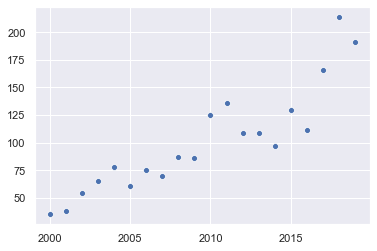

In [52]:
plt.xticks(range(2000,2019,5))
sns.scatterplot(list(eigen_dic.keys()), list(eigen_dic.values()));

In [25]:
for ano in range(2000,2020):
    basename="base{}.gml".format(ano)
    with open(basename,"w") as content:
        content.writelines("graph [\n  directed 1\n")
        for i in range(len(lista_cantores[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_cantores[ano][i])
            content.writelines(line)
        for i in range(len(lista_musicas[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[ano][i])
            content.writelines(line)
        for i in range(len(lista_participacao[ano])):
            line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_participacao[ano][i][0],lista_participacao[ano][i][1],1)
            content.writelines(line)
        content.writelines("]")
        

In [26]:
import seaborn as sns

import networkx as nx

import freeman as fm

import operator

from statistics import mean

In [27]:
def get_sorted_list_from_dict(dic):
    dic_f = sorted(dic.items(), key=operator.itemgetter(1))
    ckeys=range(len(dic_f))
    keys=[]
    values=[]
    for i in dic_f:
        keys.append(i[0])
        values.append(i[1])
    return ckeys, keys, values, dic_f

In [28]:
def eigen(T,row):
    return T[row["SongFiltred"]]

In [29]:
def variaveis2(dataf, year, T):
    dataframe=dataf[year].copy()
    
    def go_to_apply (row):
        return T[row["SongFiltred"]]

    dataframe["eigen"] = dataframe.apply (lambda row: go_to_apply(row), axis=1)

    return dataframe

***Seção de Métrica***

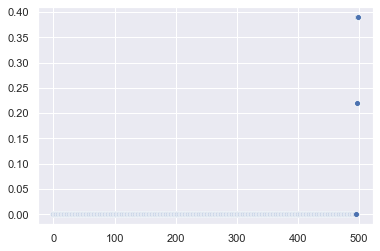

média: 0.002004008016032064
Atores mais importantes:


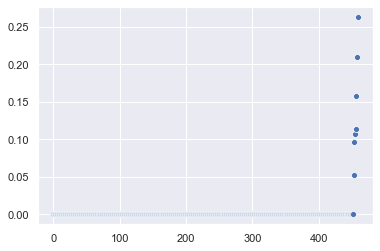

média: 0.002173913043478261
Atores mais importantes:


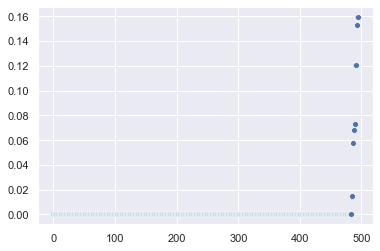

média: 0.00202020202020202
Atores mais importantes:


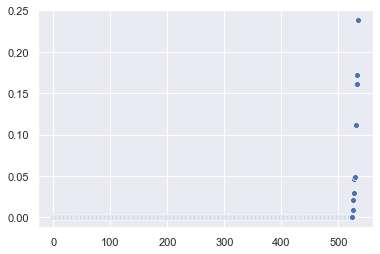

média: 0.0018691588785046734
Atores mais importantes:


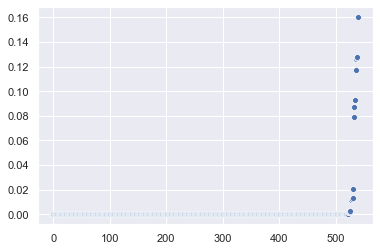

média: 0.0018518518518518521
Atores mais importantes:


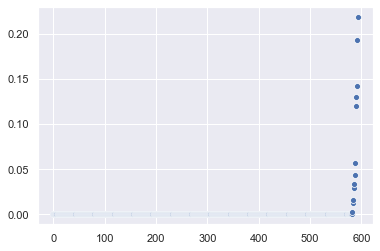

média: 0.0016835016835016836
Atores mais importantes:


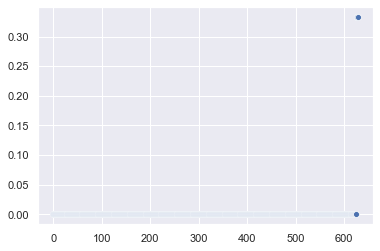

média: 0.0015898251192368843
Atores mais importantes:


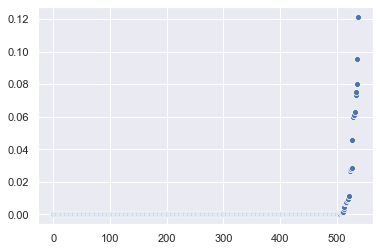

média: 0.001858736059479554
Atores mais importantes:


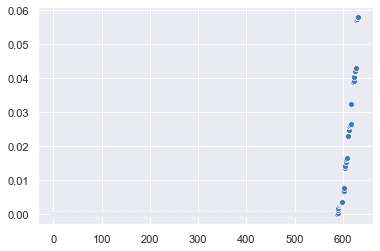

média: 0.001582278481012658
Atores mais importantes:


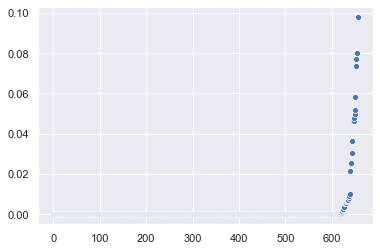

média: 0.0015220700152207003
Atores mais importantes:


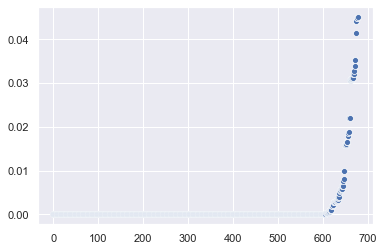

média: 0.0014727540500736379
Atores mais importantes:


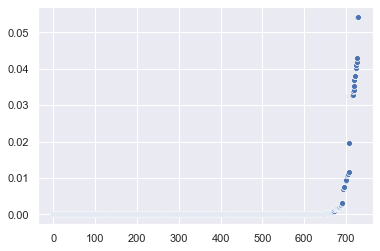

média: 0.0013717421124828536
Atores mais importantes:


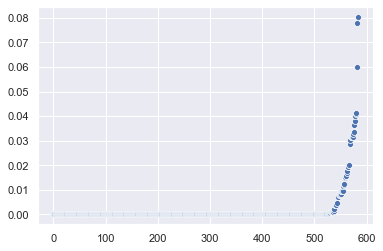

média: 0.0017123287671232874
Atores mais importantes:


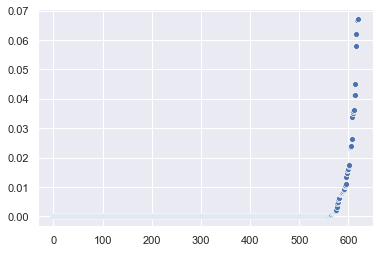

média: 0.0016129032258064518
Atores mais importantes:


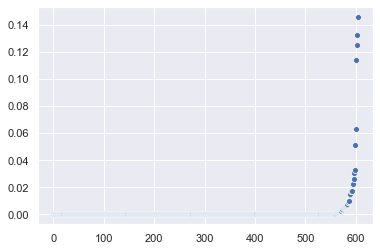

média: 0.0016528925619834715
Atores mais importantes:


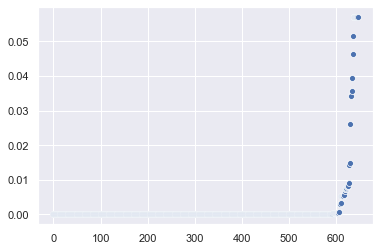

média: 0.0015455950540958266
Atores mais importantes:


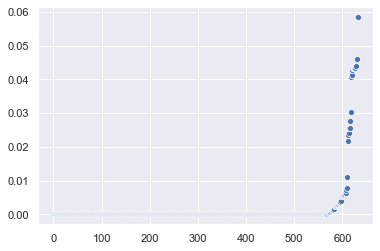

média: 0.0015797788309636653
Atores mais importantes:


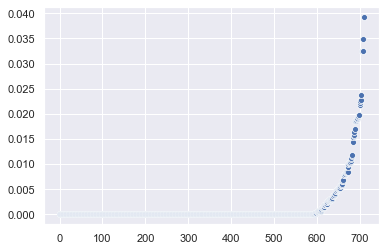

média: 0.0014084507042253518
Atores mais importantes:


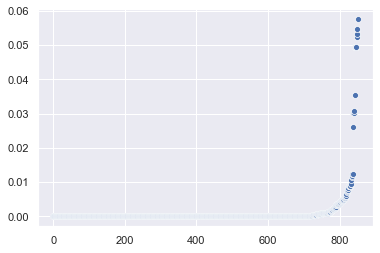

média: 0.0011737089201877937
Atores mais importantes:


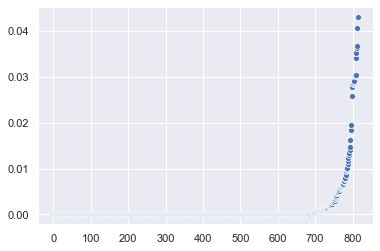

média: 0.0012269938650306747
Atores mais importantes:


In [55]:

for ano in range(2000,2020):
    basename="base{}.gml".format(ano)
    g = fm.load(basename)

    g.label_nodes()
    g.set_all_nodes(size=1, labpos='hover')
    g.set_all_edges(color=(0, 0, 0, 0.5))
    t1,t2 = nx.hits(g, max_iter=100000, tol=1e-06, nstart=None, normalized=True)
   
    dic_dataframe[ano]=variaveis2(dic_dataframe,ano,t1)
    
    bc_ck,bc_k,bc_v,bc_df=get_sorted_list_from_dict(t1)
    sns.scatterplot(bc_ck, bc_v);
    plt.show()

    print("média: {}".format(mean(bc_v)))
    print("Atores mais importantes:")


***Seção de Teste de Hipótese***

In [54]:
model = sm.OLS(dic_dataframe[2005]["loginv"], dic_dataframe[2005][['eigen']])
result = model.fit()
pd.set_option('display.float_format', lambda x: '%.1f' % x)
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 loginv   R-squared (uncentered):                   0.019
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              6.305
Date:                Thu, 26 Nov 2020   Prob (F-statistic):                      0.0125
Time:                        22:08:05   Log-Likelihood:                          46.977
No. Observations:                 322   AIC:                                     -91.95
Df Residuals:                     321   BIC:                                     -88.18
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
eigen          1.3848      0.552      2.511      0.013       0.300       2.470
==============================================================================
Omnibus:                      408.302   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55924.363
Skew:                           5.587   Prob(JB):                         0.00
Kurtosis:                      66.588   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# for ano in range(2000,2020):
#     genre="genre{}.gml".format(ano)
#     with open(genre,"w") as content:
#         content.writelines("graph [\n  directed 1\n")
#         for i in range(len(lista_generos[ano])):
#             line="  node [\n    id \"{}\"\n  ]\n".format(lista_generos[ano][i])
#             content.writelines(line)
#         for i in range(len(lista_musicas[ano])):
#             line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[ano][i])
#             content.writelines(line)
#         for i in range(len(lista_musicas_generos[ano])):
#             line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[ano][i][0],lista_musicas_generos[ano][i][1],1)
#             content.writelines(line)
#             line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[ano][i][1],lista_musicas_generos[ano][i][0],1)
#             content.writelines(line)
#         content.writelines("]")

In [33]:
# for ano in range(2000,2020):
#     genre="genre{}.gml".format(ano)
#     g = fm.load(genre)

#     g.label_nodes()
#     g.set_all_nodes(size=1, labpos='hover')
#     g.set_all_edges(color=(0, 0, 0, 0.5))
#     t1= nx.betweenness_centrality(g, normalized=True)
    

    
#     bc_ck,bc_k,bc_v,bc_df=get_sorted_list_from_dict(t1)
    
#     sns.scatterplot(bc_ck, bc_v);
#     plt.show()

#     print("média: {}".format(mean(bc_v)))
#     print("Atores mais importantes:")
#     print(bc_df)

In [34]:
# h = fm.load('genre2000.gml')

# h.label_nodes()
# h.set_all_nodes(size=1, labpos='hover')
# h.set_all_edges(color=(0, 0, 0, 0.5))

# h.interact()